In [ ]:
!pip install -q pytorch_lightning
!pip install pyrender
%pip install scipy

In [1]:
import time

import numpy as np
import cv2
from scipy.spatial.transform import Rotation as R
#from google.colab.patches import cv2_imshow

import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch import Tensor, nn
from torch.nn import functional as F
import pyrender
import trimesh
from numpy.linalg import inv
import pytorch_lightning as pl
import random

import time
import threading

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger


In [2]:
def build_conv_layer(fi, fo, k=3, upscale=False, pool=False, last=False):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False) 
            if upscale else nn.Identity(),
        nn.Conv2d(fi, fo, kernel_size=3, padding=k//2),
        nn.ReLU(inplace=True) if not last else nn.Identity(),
        nn.BatchNorm2d(fo) if not last else nn.Identity(),
        nn.MaxPool2d(2, 2) if pool else nn.Identity(),
    )

class BaseModel(pl.LightningModule):
    """small encoder-decoder cnn"""
    n_pts: int
    n_channels: int

    def __init__(self, left=(8, 16, 32,64,128,256), right=(256,128,64,32, 16, 8), lr=1e-3):
        super().__init__()
        self.lr = lr
        left = self.n_channels, *left
        right = *right, self.n_pts
        assert len(left) == len(right)
        layers = [build_conv_layer(fi, fo, pool=True) for fi, fo in zip(left, left[1:])]
        layers += [build_conv_layer(fi, fo, upscale=True) for fi, fo in zip(right, right[1:-1])]
        layers += [build_conv_layer(right[-2], right[-1], upscale=True, last=True)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):  # (B, n_channels, h, w)
        return self.layers(x) # (B, n_pts, h, w)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

class FunDataset(torch.utils.data.Dataset):
    def __init__(self, data_fun, epoch_size=5000):
        self.data_fun = data_fun
        self.epoch_size = epoch_size
    
    def __len__(self):
        return self.epoch_size

    def __getitem__(self, _):
        return self.data_fun()

class make_dataset(torch.utils.data.Dataset):
    def __init__(self, data, epoch_size=500):
        self.data = data
        self.epoch_size = epoch_size
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]


def get_dataloader(data_fun, bs=16):
    return torch.utils.data.DataLoader(
        FunDataset(data_fun),
        batch_size=bs, 
        worker_init_fn=lambda *_: np.random.seed(None), 
        #pin_memory = True,
        num_workers=8,
    )

class MyDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.data_files = os.listdir('dataset/')

    def __getitem__(self, idx):
        return np.load("dataset/" + self.data_files[idx])

    def __len__(self):
        return len(self.data_files)


def get_trainer(max_epochs=10):

    loggerT = TensorBoardLogger("tb_logs", name="my_model")
    return pl.Trainer(
        gpus=[0], 
        logger=loggerT,# enable_checkpointing=False,
        max_epochs=max_epochs,
        #progress_bar_refresh_rate=0,
        #enable_model_summary=False,
    )

## Marginal keypoint distributions of points on a circle

Learn to estimate the marginal probabilities of two points
$P(u_a|I)$, $P(u_b|I)$.




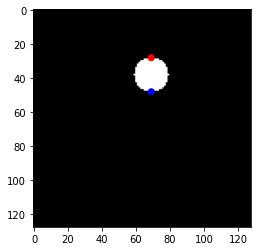

In [2]:
def circle_data_fun(res=128, radius=10, n_pts=2):
    theta_pts_obj = np.linspace(0, 2 * np.pi, n_pts, endpoint=False)
    
    center = np.random.randint(radius, res - radius, 2)
    theta = np.random.rand() * np.pi * 2

    img = np.zeros((res, res), dtype=np.float32)
    cv2.circle(img, tuple(center), radius, color=1., thickness=-1)
    
    theta_cam_pts = theta + theta_pts_obj
    pts = center + np.array((
        np.cos(theta_cam_pts), 
        np.sin(theta_cam_pts)
    )).T * radius
    return img, np.round(pts).astype(int)

img, pts = circle_data_fun()
plt.imshow(img, cmap='gray')
plt.scatter(*pts.T, c=[(1, 0, 0), (0, 0, 1)])
plt.show()

In [ ]:
class MarginalModel(BaseModel):
    n_pts = 2
    n_channels = 1

    def training_step(self, batch, _):
        img, pts = batch  # (B, h, w), (B, 2, 2xy), (B,)
        # pts is a tensor shaped with a sample/batch of batch_size(in this case 16) each of these samples consists of a tensor of size 2 containing tensors on each index.
        # The tensors within is also of size 2 and consist of a point pair.
        # img is pretty self explanory.
        B, h, w = img.shape
        #print(pts.shape)
        xx, yy = pts.permute(2, 0, 1) # takes out the two x-values or y-values and stores them as a tensor within a tensor with size batch_size(in this case 16)
        target = yy * w + xx  # (B, 2)
        
        lgts = self.forward(img[:, None])  # (B, n_pts, h, w)
        lgts = lgts.view(B, 2, -1)


        loss = F.cross_entropy(
            lgts.view(B * self.n_pts, -1), 
            target.view(B * self.n_pts)
        )
        return loss

# if os.path.exists("model.pkl"):
#   model = torch.load("model.pkl")
# else:
model = MarginalModel()
get_trainer(max_epochs=10).fit(model, get_dataloader(circle_data_fun))
  # torch.save(model,"model.pkl")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 12.0 K
--------------------------------------
12.0 K    Trainable params
0         Non-trainable params
12.0 K    Total params
0.048     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

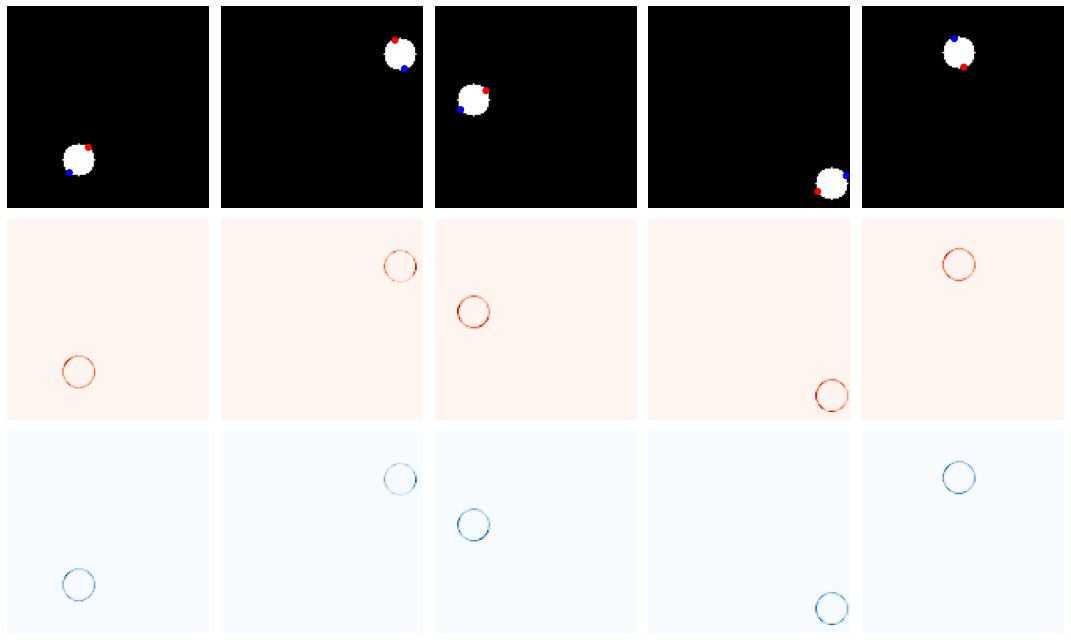

In [ ]:
n_rows, n_cols, size = 3, 5, 3
axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*size, n_rows*size))[1]
model.eval()
with torch.no_grad():
    for ax_col in axs.T:
        img, pts = circle_data_fun() # Make new dataset
        h, w = img.shape
        lgts = model.forward(torch.from_numpy(img)[None, None])[0]  # (n_pts, h, w)
        probs = F.softmax(lgts.view(2, -1), dim=1).view(2, h, w)
        ax_col[0].imshow(img, cmap='gray')
        ax_col[0].scatter(*pts.T, c=[(1, 0, 0), (0, 0, 1)])
        ax_col[1].imshow(probs[0], cmap='Reds')
        ax_col[2].imshow(probs[1], cmap='Blues')
for ax in axs.reshape(-1):
    ax.axis('off')
plt.tight_layout()

More training should lead to smoother distributions.

# Joint distribution and an autoregressive approach

Sampling sets of correspondences from the marginal distributions leads to incoherent sets in case of ambiguity (e.g. the full rotational symmetry of a circle).

If we want to sample sets of coherent correspondences, basically we're interested in sampling sets from the joint correspondence probabilities $P(u_1, u_2, ..., u_n | I)$. Representing the joint probability directly however does not scale well with respect to resolution and keypoints.

Note that we can decompose the joint distribution:  
$P(u_1, u_2, ..., u_n | I) = P(u_1 | I) \cdot P(u_2| u_1, I) \cdot ... \cdot P(u_n| u_1, u_2, ..., u_{n-1}, I)$.

If we learn $P(u_1 | I)$, $P(u_2 | u_1, I)$, ..., $P(u_n| u_1, u_2, ..., u_{n-1}, I)$, we can thus sample from the joint probability distriution by sampling $u_1$ from $P(u_1 | I)$, then sampling $u_2$ from $P(u_2 | u_1, I)$ and so on.


Things to consider:
* How do the two approaches (joint, autoregressive) scale with respect to resolution, (h, w), number of keypoints, n, and number of sets to sample, m?
* Encoder-decoder CNN models have been developed to model P(u | I), but how do we condition on previous samples? For example, how do we present the sample $u_1$ to the model P(u_2 | u_1, I)? Consider at least translational equivariance and efficient sampling.

In [ ]:

def joint_data_fun():
    img, pts = circle_data_fun()
    h, w = img.shape
    temp = np.zeros((h,w),dtype=np.uint8)
    #print(pts[0])
    temp[pts[0][1],pts[0][0]]=1
    #print(temp.argmax())
    img = np.append(img,temp)
    img = img.reshape(2,h,w)
    # print(img.shape)
    # img = cv2.merge((img,temp))
    # maxproppos = probs[0].argmax
    # print(maxproppos)
    # print(type(pts))
    #print(img[:,:,1])
    return img, pts


class JointModel(BaseModel):
    n_pts = 1
    n_channels = 2

    def training_step(self, batch, _):
        img, pts = batch
        # print(img.shape)
        B, h, w ,c = img.shape
        #print(pts.shape)
        xx, yy = pts[:,1].permute( 1,0 )
        #print("xx: ", xx, " yy: ",yy)
        # print("w ", w)
        target = yy * w + xx

        lgts = self.forward(img[:])
        #print(lgts.shape)
        lgts = lgts.view(B,1,-1)

        loss = F.cross_entropy(
            lgts.view(B,-1),  
            target.view(B)
        )
        return loss

model_joint = JointModel()
get_trainer(max_epochs=10).fit(model_joint,get_dataloader(joint_data_fun))    
#joint_data_fun()


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 12.0 K
--------------------------------------
12.0 K    Trainable params
0         Non-trainable params
12.0 K    Total params
0.048     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Lav nyt data set med circle_data_fun efter endt træning af marginalmodel som kan evalueres med modellen. Fra dette dataset har vi image og points som skal bruges til næste træning med tilhørende max prob fra tidligere.



tensor(0.5445)
tensor(0.9014)
tensor(0.6258)
tensor(0.4920)
tensor(0.5578)


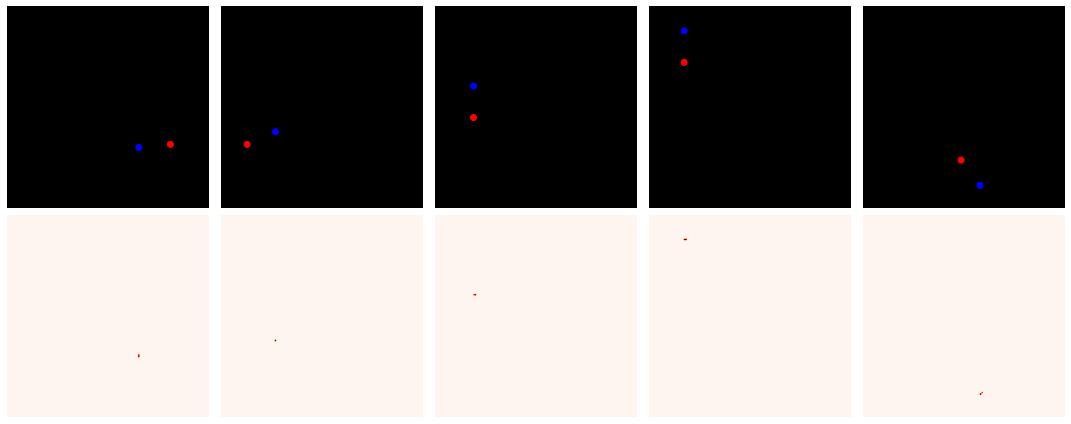

In [ ]:
n_rows, n_cols, size = 2, 5, 3
axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*size, n_rows*size))[1]
model_joint.eval()
with torch.no_grad():
    for ax_col in axs.T:
        img, pts = joint_data_fun()
        # print(img.shape)
        c, h, w = img.shape
        lgts = model_joint.forward(torch.from_numpy(img)[None])[0]  # (n_pts, h, w)
        probs = F.softmax(lgts.view(1, -1), dim=1).view(1, h, w)
        #print(probs[0])
        y = np.floor(np.argmax(probs[0].cpu().detach().numpy())/128)

        x = np.floor(np.argmax(probs[0].cpu().detach().numpy())%128)
        print(torch.max(probs[0]))
        ax_col[0].imshow(img[1], cmap='gray')
        ax_col[0].scatter(*pts.T, c=[(1, 0, 0), (0, 0, 1)])
        ax_col[1].imshow(probs[0], cmap='Reds')
        #ax_col[1].scatter(x,y, c=[(0, 0, 1)])
for ax in axs.reshape(-1):
    ax.axis('off')
plt.tight_layout()

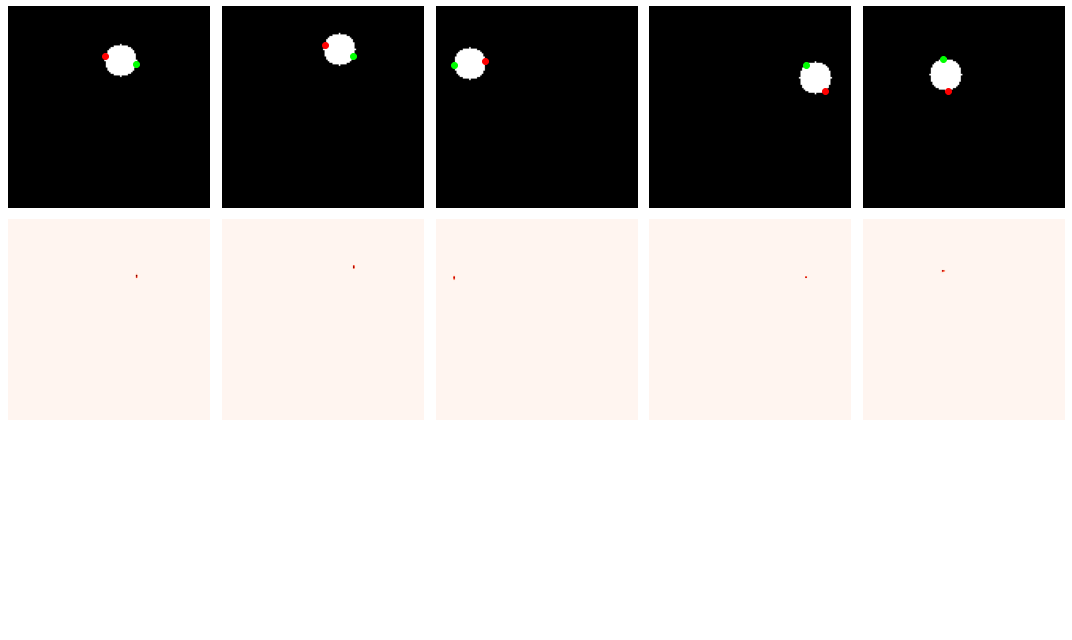

In [ ]:
n_rows, n_cols, size = 3, 5, 3
axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*size, n_rows*size))[1]
model.eval()
model_joint.eval()
with torch.no_grad():
  for ax_col in axs.T:
        img, pts = circle_data_fun() # Make new dataset
        h, w = img.shape
        lgts = model.forward(torch.from_numpy(img)[None, None])[0]  # (n_pts, h, w)
        probs = F.softmax(lgts.view(2, -1), dim=1).view(2, h, w)
        numpyprob0 = probs[0].cpu().detach().numpy()
        numpyprob0 = numpyprob0.reshape(-1)
        index = np.zeros(128*128)
        for i in range(0,128*128):
          index[i] = i
        pt0 = np.random.choice(a=index,p=numpyprob0)
        y = np.floor(pt0/128)
        x = np.floor(pt0%128)


        # add channel
        temp = np.zeros((h,w),dtype=np.uint8)
        #print(pts[0])
        temp[int(y),int(x)]=1
        #print(temp.argmax())
        img = np.append(img,temp)
        img = img.reshape(2,h,w)

        # eval joint
        lgts_joint = model_joint.forward(torch.from_numpy(img)[None])[0]  # (n_pts, h, w)
        probs_joint = F.softmax(lgts_joint.view(1, -1), dim=1).view(1, h, w)
        

        ax_col[0].imshow(img[0], cmap='gray')
        ax_col[0].scatter(x,y, c=[(1, 0, 0)])
        
        #print(probs_joint.shape)
        ax_col[1].imshow(probs_joint[0], cmap='Reds')

        y = np.floor(np.argmax(probs_joint[0].cpu().detach().numpy())/128)

        x = np.floor(np.argmax(probs_joint[0].cpu().detach().numpy())%128)
        #ax_col[1].imshow(img[0], cmap='gray')
        ax_col[0].scatter(x,y, c=[(0, 1, 0)])
        
        
for ax in axs.reshape(-1):
    ax.axis('off')
plt.tight_layout()

Forsøg med kugle

In [3]:
# Implementation of code from Troels' test:

# Map the 3d point to pixel value
def map_to_pixel(point_pose,w,h,projection,view):
    point3d = np.array([point_pose[0][3],point_pose[1][3],point_pose[2][3],1.])
    p=projection@inv(view)@point3d
    p=p/p[3]
    p[0]=round(w/2*p[0]+w/2)   #tranformation from [-1,1] ->[0,width]
    p[1]=round(h-(h/2*p[1]+h/2))  #tranformation from [-1,1] ->[0,height] (top-left image)
    
    return p.astype(int)

def random_transform_matrix():
  
  # x = random.uniform(0,90)
  # y = random.uniform(0,90)
  # z = random.uniform(0,90)
  rot = R.random().as_matrix()
  T = np.eye(4)
  translation = np.random.uniform(low = -1.7 , high = 1.7 , size = (3))
  translation[2] = 0
  T[:3,:3] = rot
  T[:3,3] = translation
  
  return T

def spherical_data_fun(model_number):
  # Generate the sphere and points:
  sphere = trimesh.creation.icosphere(subdivisions=3, radius=1.0, color=None)
  sphere.visual.vertex_colors = [200, 0, 250, 100]
  sphere_mesh = pyrender.Mesh.from_trimesh(sphere)

  point = trimesh.creation.icosphere(subdivisions=3, radius=0.1, color=None)
  point1_mesh = pyrender.Mesh.from_trimesh(point)
  point2_mesh = pyrender.Mesh.from_trimesh(point)
  point3_mesh = pyrender.Mesh.from_trimesh(point)
  point4_mesh = pyrender.Mesh.from_trimesh(point)

  # Pose for the sphere and camera
  sphere_pose = np.array([[[1. , 0. , 0. , 0. ],
                      [0. , 1. , 0. , 0. ],
                      [0. , 0. , 1. , 0. ],
                      [0. , 0. , 0. , 1. ]]])
    
  cam_pose = np.array([[1. , 0. , 0. , 0.],
                      [0. , 1. , 0. , 0. ],
                      [0. , 0. , 1. , 5. ],
                      [0. , 0. , 0. , 1. ]])

  # Poses for the points
  point_poses = np.array([[[1. , 0. , 0. , 1.],
                      [0. , 1. , 0. , 0. ],
                      [0. , 0. , 1. , 0. ],
                      [0. , 0. , 0. , 1. ]],
                  [[1. , 0. , 0. , -1.],
                      [0. , 1. , 0. , 0. ],
                      [0. , 0. , 1. , 0. ],
                      [0. , 0. , 0. , 1. ]],
                  [[1. , 0. , 0. , 0.],
                      [0. , 1. , 0. , 1. ],
                      [0. , 0. , 1. , 0. ],
                      [0. , 0. , 0. , 1. ]],
                  [[1. , 0. , 0. , 0.],
                      [0. , 1. , 0. , -1. ],
                      [0. , 0. , 1. , 0. ],
                      [0. , 0. , 0. , 1. ]]])

  # Setup the perspective camera:
  cam = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, aspectRatio=1.0)

  # Setup the scene and add the camera and the sphere+points with random rotation
  scene = pyrender.Scene()

  # Get the random transformation matrix:
  rand_trans = random_transform_matrix()

  scene.add(sphere_mesh, pose=sphere_pose[0]@rand_trans)
  # scene.add(point1_mesh, pose=rand_trans@point_poses[0])
  # scene.add(point2_mesh, pose=rand_trans@point_poses[1])
  # scene.add(point3_mesh, pose=rand_trans@point_poses[2])
  # scene.add(point4_mesh, pose=rand_trans@point_poses[3])
  scene.add(cam, pose=cam_pose, name='CAM')

  # Projection matrix
  pro_mat = cam.get_projection_matrix()

  # Setup the Off-screen Rendering
  #start = time.time()
  width = 128
  height = 128
  render = pyrender.offscreen.OffscreenRenderer(width, height) # width, height
  img, depth = render.render(scene)
  #print("data fun",time.time() - start)
  
  # Test how the image looks:
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  # cv2_imshow(img)
  

  # Get the 2d pixel location from the points
  result1 = map_to_pixel(rand_trans@point_poses[0], width, height, pro_mat, cam_pose)
  result2 = map_to_pixel(rand_trans@point_poses[1], width, height, pro_mat, cam_pose)
  result3 = map_to_pixel(rand_trans@point_poses[2], width, height, pro_mat, cam_pose)
  result4 = map_to_pixel(rand_trans@point_poses[3], width, height, pro_mat, cam_pose)
  h = height
  w = width
  
  
  if model_number == 1:
    pts = np.array([result1[:2],result2[:2],result3[:2],result4[:2]]).reshape(4,2)
    img = np.expand_dims(img,axis = 0)
  elif model_number == 2:
    pts = np.array([result1[:2],result2[:2],result3[:2],result4[:2]]).reshape(4,2)
    temp = np.zeros((h,w),dtype=np.uint8)
    temp[int(pts[0][1]),int(pts[0][0])]=1
    img = np.append(img,temp)
    img = img.reshape(2,h,w)
  elif model_number == 3:
    pts = np.array([result1[:2],result2[:2],result3[:2],result4[:2]]).reshape(4,2)
    temp = np.zeros((h,w),dtype=np.uint8)
    temp[int(pts[0][1]),int(pts[0][0])]=1
    img = np.append(img,temp)
    img = img.reshape(2,h,w)
    temp = np.zeros((h,w),dtype=np.uint8)
    temp[int(pts[1][1]),int(pts[1][0])]=1
    img = np.append(img,temp)
    img = img.reshape(3,h,w)
  elif model_number == 4:
    pts = np.array([result1[:2],result2[:2],result3[:2],result4[:2]]).reshape(4,2)
    temp = np.zeros((h,w),dtype=np.uint8)
    temp[int(pts[0][1]),int(pts[0][0])]=1
    img = np.append(img,temp)
    img = img.reshape(2,h,w)
    temp = np.zeros((h,w),dtype=np.uint8)
    temp[int(pts[1][1]),int(pts[1][0])]=1
    img = np.append(img,temp)
    img = img.reshape(3,h,w)
    temp = np.zeros((h,w),dtype=np.uint8)
    temp[int(pts[2][1]),int(pts[2][0])]=1
    img = np.append(img,temp)
    img = img.reshape(4,h,w)

  # print("result pixel value point 1:: ", result1)
  # print("result pixel value point 2:: ", result2)
  # print("result pixel value point 3:: ", result3)
  # print("result pixel value point 4:: ", result4)
  return img, pts

testimg, testpts = spherical_data_fun(3)

print(testimg)

[[[255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]]

 [[  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  ...
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]]

 [[  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  ...
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]]]


In [4]:
class sphereModel1(BaseModel):
  n_pts = 1
  n_channels = 1

  def training_step(self, batch, _):
    temp = batch
    img  = temp[:,0,:,:]
    img = torch.unsqueeze(img,1)
    print(img.shape)
    target = 0
    for i in range(temp.shape[0]):
    #     for c in range(4):
        if target == 0:
            target = [temp[i,1,:,:].cpu().numpy().argmax()]
        else:
            target_arg = temp[i,1,:,:].cpu().numpy().argmax()
            target.append(target_arg)
            #     #print(type(target))
                #print(target_arg)
    target = torch.as_tensor(np.array(target),device=img.device)
    B, c, h, w = img.shape
    #print(target)
    #print(pts.shape)
    #xx, yy = pts.permute(2, 0, 1) # takes out the two x-values or y-values and stores them as a tensor within a tensor with size batch_size(in this case 16)
    #target = yy * w + xx  # (B, 2)

    lgts = self.forward(img[:].float())  # (B, n_pts, h, w)
    lgts = lgts.view(B, self.n_pts, -1)


    loss = F.cross_entropy(
        lgts.view(B * self.n_pts, -1), 
        target.view(B * self.n_pts)
    )
    return loss

    
class sphereModel2(BaseModel):
  n_pts = 1
  n_channels = 2

  def training_step(self, batch, _):
    temp = batch
    img  = temp[:,:2,:,:]
    #img = torch.unsqueeze(img,1)
    #print(img.shape)
    target = 0
    for i in range(temp.shape[0]):
        #for c in range(3):
        if target == 0:
            target = [temp[i,2,:,:].cpu().numpy().argmax()]
        else:
            target_arg = temp[i,2,:,:].cpu().numpy().argmax()
            target.append(target_arg)
            #print(type(target))
                #print(target_arg)
    target = torch.as_tensor(np.array(target),device=img.device)
        # print(img.shape)
    B, c, h, w = img.shape
    # xx, yy = pts[:,1:].permute(2, 0, 1)# index maybe wrong # takes out the two x-values or y-values and stores them as a tensor within a tensor with size batch_size(in this case 16)
    # target = yy * w + xx  # (B, 2)
    
    # print(img)
    lgts = self.forward(img[:].float())  # (B, n_pts, h, w)
    lgts = lgts.view(B, self.n_pts, -1)


    loss = F.cross_entropy(
        lgts.view(B * self.n_pts, -1), 
        target.view(B * self.n_pts)
    )
    return loss

class sphereModel3(BaseModel):
  n_pts = 1
  n_channels = 3

  def training_step(self, batch, _):
    temp = batch
    img  = temp[:,:3,:,:]
    #img = torch.unsqueeze(img,1)
    #print(img.shape)
    target = 0
    for i in range(temp.shape[0]):
        #for c in range(2):
        if target == 0:
            target = [temp[i,3,:,:].cpu().numpy().argmax()]
        else:
            target_arg = temp[i,3,:,:].cpu().numpy().argmax()
            target.append(target_arg)
                #print(type(target))
                #print(target_arg)
    target = torch.as_tensor(np.array(target),device=img.device)
        # print(img.shape)
    B, c, h, w = img.shape
    # xx, yy = pts[:,2:].permute(2, 0, 1) # takes out the two x-values or y-values and stores them as a tensor within a tensor with size batch_size(in this case 16)
    # target = yy * w + xx  # (B, 2)
    
    lgts = self.forward(img[:].float())  # (B, n_pts, h, w)
    lgts = lgts.view(B, self.n_pts, -1)


    loss = F.cross_entropy(
        lgts.view(B * self.n_pts, -1), 
        target.view(B * self.n_pts)
    )
    return loss

class sphereModel4(BaseModel):
  n_pts = 1
  n_channels = 4

  def training_step(self, batch, _):
    temp = batch
    img  = temp[:,:4,:,:]
    #img = torch.unsqueeze(img,1)
    #print(img.shape)
    target = 0
    for i in range(temp.shape[0]):
        #for c in range(1):
        if target == 0:
            target = [temp[i,4,:,:].cpu().numpy().argmax()]
        else:
            target_arg = temp[i,4,:,:].cpu().numpy().argmax()
            target.append(target_arg)
                #print(type(target))
                #print(target_arg)
    target = torch.as_tensor(np.array(target),device=img.device)
        # print(img.shape)
    B, c, h, w = img.shape
    # xx, yy = pts[:,3:].permute(2, 0, 1) # takes out the two x-values or y-values and stores them as a tensor within a tensor with size batch_size(in this case 16)
    # target = yy * w + xx  # (B, 2)
    
    lgts = self.forward(img[:].float())  # (B, n_pts, h, w)
    lgts = lgts.view(B, self.n_pts, -1)


    loss = F.cross_entropy(
        lgts.view(B * self.n_pts, -1), 
        target.view(B * self.n_pts)
    )
    return loss

def spherical_data_fun1():
  return spherical_data_fun(1)
  
def spherical_data_fun2():
  return spherical_data_fun(2)

def spherical_data_fun3():
  return spherical_data_fun(3)

def spherical_data_fun4():
  return spherical_data_fun(4)

model_sphere1 = sphereModel1()
model_sphere2 = sphereModel2()
model_sphere3 = sphereModel3()
model_sphere4 = sphereModel4()

# get_trainer(max_epochs=10).fit(model_sphere1,dataset_loader)
# get_trainer(max_epochs=10).fit(model_sphere2,dataset_loader)
# get_trainer(max_epochs=10).fit(model_sphere3,dataset_loader)
if os.path.exists('model/model_sphere1.pkl'):
    model_sphere1 = torch.load('model/model_sphere1.pkl')
    # print('Critic Model loaded')
else:
    dataset = MyDataset()
    dataset_loader = torch.utils.data.DataLoader(dataset,batch_size=16,shuffle = True,num_workers=8,pin_memory=torch.cuda.is_available())
    get_trainer(max_epochs=10).fit(model_sphere1,dataset_loader)
    # for i in tqdm(range(50)):
    #     with open('datasettest1/' + str(i) + '.npy', 'rb') as f:
    #         a = np.load(f)

    #     dataset = make_dataset(a)
    #     dataset_loader = torch.utils.data.DataLoader(dataset,batch_size=16,shuffle = True,num_workers=2,pin_memory=torch.cuda.is_available())

    #     get_trainer(max_epochs=10).fit(model_sphere1,dataset_loader)
    torch.save(model_sphere1, 'model/model_sphere1.pkl')

if os.path.exists('model/model_sphere2.pkl'):
    model_sphere2 = torch.load('model/model_sphere2.pkl')
    # print('Critic Model loaded')
else:
    dataset = MyDataset()
    dataset_loader = torch.utils.data.DataLoader(dataset,batch_size=16,shuffle = True,num_workers=8,pin_memory=torch.cuda.is_available())
    get_trainer(max_epochs=10).fit(model_sphere2,dataset_loader)
    # for i in tqdm(range(50)):
    #     with open('datasettest1/' + str(i) + '.npy', 'rb') as f:
    #         a = np.load(f)

    #     dataset = make_dataset(a)
    #     dataset_loader = torch.utils.data.DataLoader(dataset,batch_size=16,shuffle = True,num_workers=2,pin_memory=torch.cuda.is_available())

    #     get_trainer(max_epochs=10).fit(model_sphere2,dataset_loader)
    torch.save(model_sphere2, 'model/model_sphere2.pkl')


if os.path.exists('model/model_sphere3.pkl'):
    model_sphere3 = torch.load('model/model_sphere3.pkl')
    # print('Critic Model loaded')
else:
    dataset = MyDataset()
    dataset_loader = torch.utils.data.DataLoader(dataset,batch_size=16,shuffle = True,num_workers=8,pin_memory=torch.cuda.is_available())
    get_trainer(max_epochs=10).fit(model_sphere3,dataset_loader)
    # for i in tqdm(range(50)):
    #     with open('datasettest1/' + str(i) + '.npy', 'rb') as f:
    #         a = np.load(f)

    #     dataset = make_dataset(a)
    #     dataset_loader = torch.utils.data.DataLoader(dataset,batch_size=16,shuffle = True,num_workers=2,pin_memory=torch.cuda.is_available())

    #     get_trainer(max_epochs=10).fit(model_sphere3,dataset_loader)
    torch.save(model_sphere3, 'model/model_sphere3.pkl')


if os.path.exists('model/model_sphere4.pkl'):
    model_sphere4 = torch.load('model/model_sphere4.pkl')
    # print('Critic Model loaded')
else:
    dataset = MyDataset()
    dataset_loader = torch.utils.data.DataLoader(dataset,batch_size=16,shuffle = True,num_workers=8,pin_memory=torch.cuda.is_available())
    get_trainer(max_epochs=10).fit(model_sphere4,dataset_loader)
    # for i in tqdm(range(50)):
    #     with open('datasettest1/' + str(i) + '.npy', 'rb') as f:
    #         a = np.load(f)

    #     dataset = make_dataset(a)
    #     dataset_loader = torch.utils.data.DataLoader(dataset,batch_size=16,shuffle = True,num_workers=2,pin_memory=torch.cuda.is_available())

    #     get_trainer(max_epochs=10).fit(model_sphere4,dataset_loader)
    torch.save(model_sphere4, 'model/model_sphere4.pkl')

# def wrap_thread(index):
#   if index == 1:
#     get_trainer(max_epochs=10).fit(model_sphere1,dataset_loader)
#   elif index == 2:
#     get_trainer(max_epochs=10).fit(model_sphere2,dataset_loader)
#   elif index == 3:
#     get_trainer(max_epochs=10).fit(model_sphere3,dataset_loader)
#   elif index == 4:
#     get_trainer(max_epochs=10).fit(model_sphere4,dataset_loader)

# threads = list()

# for index in range(1,2):
#   x = threading.Thread(target=wrap_thread, args=(index,))
#   threads.append(x)
#   x.start()

# for thread in threads:
#   thread.join()




GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: tb_logs/my_model

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 788 K 
--------------------------------------
788 K     Trainable params
0         Non-trainable params
788 K     Total params
3.152     Total estimated model params size (MB)


Epoch 0:  46%|████▌     | 941/2063 [00:36<00:43, 25.76it/s, loss=7.86, v_num=0]torch.Size([16, 1, 128, 128])


/home/henning/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 788 K 
--------------------------------------
788 K     Trainable params
0         Non-trainable params
788 K     Total params
3.153     Total estimated model params size (MB)


Epoch 0:  21%|██        | 433/2063 [00:15<00:58, 27.70it/s, loss=7.9, v_num=1] 

(1, 128, 128)
torch.Size([1, 128, 128])
pts [[64 71]
 [28 56]
 [56 46]
 [33 83]]
x 46.0
y 63.0
(1, 128, 128)
torch.Size([1, 128, 128])
pts [[84 54]
 [88 17]
 [81 46]
 [93 18]]
x 85.0
y 36.0
(1, 128, 128)
torch.Size([1, 128, 128])
pts [[ 54  94]
 [ 62  94]
 [ 77  82]
 [ 40 106]]
x 59.0
y 92.0
(1, 128, 128)
torch.Size([1, 128, 128])
pts [[64 53]
 [72 64]
 [88 59]
 [45 55]]
x 68.0
y 57.0
(1, 128, 128)
torch.Size([1, 128, 128])
pts [[ 83 107]
 [118  78]
 [114 111]
 [ 90  80]]
x 104.0
y 92.0


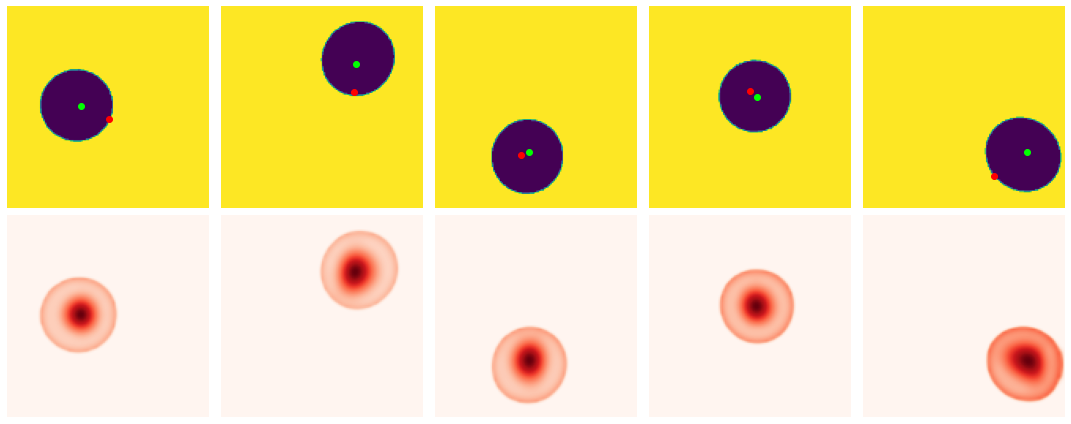

In [33]:
n_rows, n_cols, size = 2, 5, 3
axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*size, n_rows*size))[1]
model_sphere1.eval()
with torch.no_grad():
  for ax_col in axs.T:
        img, pts = spherical_data_fun(1) # Make new dataset
        print(img.shape)
        c, h, w = img.shape
        lgts = model_sphere1.forward(torch.from_numpy(img).float()[None])[0]  # (n_pts, h, w)
        probs = F.softmax(lgts.view(1, -1), dim=1).view(1, h, w)
        print(probs.shape)
        numpyprob0 = probs[0].cpu().detach().numpy()
        # cv2.imshow("test",numpyprob0)
        # cv2.waitKey(0)
        numpyprob0 = numpyprob0.reshape(-1)
        index = np.zeros(128*128)
        for i in range(0,128*128):
          index[i] = i
        pt0 = np.random.choice(a=index,p=numpyprob0)
        y = np.floor(pt0/128)
        x = np.floor(pt0%128)
        print("pts", pts)
        # print("x", x)
        # print("y",y)


        # add channel
        temp = np.zeros((h,w),dtype=np.uint8)
        #print(pts[0])
        temp[int(y),int(x)]=1
        #print(temp.argmax())
        img = np.append(img,temp)
        img = img.reshape(-1,h,w)

        # # eval joint
        # lgts_joint = model_joint.forward(torch.from_numpy(img)[None])[0]  # (n_pts, h, w)
        # probs_joint = F.softmax(lgts_joint.view(1, -1), dim=1).view(1, h, w)
        

        ax_col[0].imshow(img[0]) # , cmap='gray'
        ax_col[0].scatter(pts[0,0],pts[0,1], c=[(1, 0, 0)])
        
        # #print(probs_joint.shape)
        ax_col[1].imshow(probs[0], cmap='Reds')

        y = np.floor(np.argmax(probs[0].cpu().detach().numpy())/128)

        x = np.floor(np.argmax(probs[0].cpu().detach().numpy())%128)
        print("x", x)
        print("y",y)
        # #ax_col[1].imshow(img[0], cmap='gray')
        ax_col[0].scatter(x,y, c=[(0, 1, 0)])
        
        
for ax in axs.reshape(-1):
    ax.axis('off')
plt.tight_layout()

(2, 128, 128)
torch.Size([1, 128, 128])
pts [[ 98 109]
 [ 80  91]
 [107 100]
 [ 66  96]]
x 66.0
y 72.0
(2, 128, 128)
torch.Size([1, 128, 128])
pts [[ 44  91]
 [ 41  99]
 [ 26 116]
 [ 55  79]]
x 47.0
y 88.0
(2, 128, 128)
torch.Size([1, 128, 128])
pts [[ 71  89]
 [ 78 101]
 [ 87 111]
 [ 61  76]]
x 72.0
y 86.0
(2, 128, 128)
torch.Size([1, 128, 128])
pts [[ 54  82]
 [ 91  91]
 [ 73 104]
 [ 67  65]]
x 76.0
y 79.0
(2, 128, 128)
torch.Size([1, 128, 128])
pts [[27 63]
 [45 72]
 [34 44]
 [35 87]]
x 49.0
y 70.0


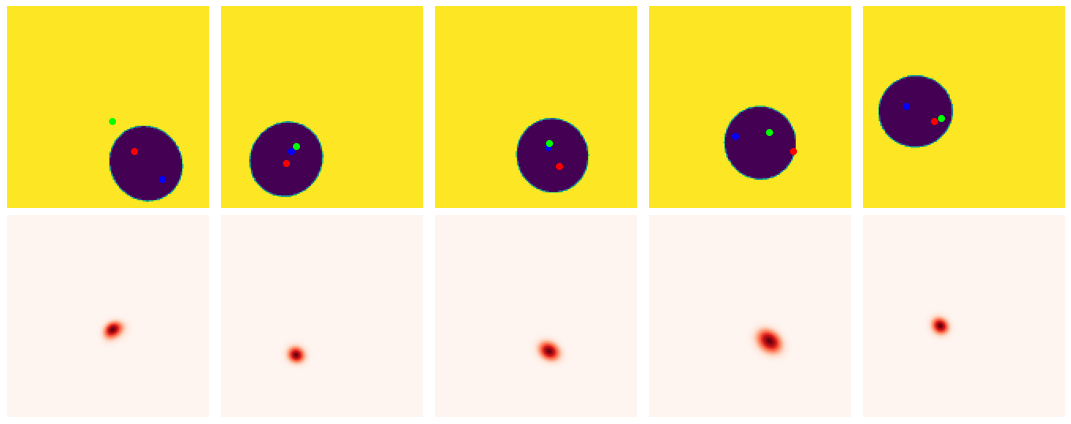

In [34]:
n_rows, n_cols, size = 2, 5, 3
axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*size, n_rows*size))[1]
model_sphere2.eval()
with torch.no_grad():
  for ax_col in axs.T:
        img, pts = spherical_data_fun(2) # Make new dataset
        print(img.shape)
        c, h, w = img.shape
        lgts = model_sphere2.forward(torch.from_numpy(img).float()[None])[0]  # (n_pts, h, w)
        probs = F.softmax(lgts.view(1, -1), dim=1).view(1, h, w)
        print(probs.shape)
        numpyprob0 = probs[0].cpu().detach().numpy()
        # cv2.imshow("test",numpyprob0)
        # cv2.waitKey(0)
        numpyprob0 = numpyprob0.reshape(-1)
        index = np.zeros(128*128)
        for i in range(0,128*128):
          index[i] = i
        pt0 = np.random.choice(a=index,p=numpyprob0)
        y = np.floor(pt0/128)
        x = np.floor(pt0%128)
        print("pts", pts)
        # print("x", x)
        # print("y",y)


        # add channel
        temp = np.zeros((h,w),dtype=np.uint8)
        #print(pts[0])
        temp[int(y),int(x)]=1
        #print(temp.argmax())
        img = np.append(img,temp)
        img = img.reshape(-1,h,w)

        # # eval joint
        # lgts_joint = model_joint.forward(torch.from_numpy(img)[None])[0]  # (n_pts, h, w)
        # probs_joint = F.softmax(lgts_joint.view(1, -1), dim=1).view(1, h, w)
        

        ax_col[0].imshow(img[0]) # , cmap='gray'
        ax_col[0].scatter(pts[1,0],pts[1,1], c=[(1, 0, 0)]) # ground true red
        ax_col[0].scatter(pts[0,0],pts[0,1], c=[(0, 0, 1)]) # sampled point blue
        
        # #print(probs_joint.shape)
        ax_col[1].imshow(probs[0], cmap='Reds')

        y = np.floor(np.argmax(probs[0].cpu().detach().numpy())/128)

        x = np.floor(np.argmax(probs[0].cpu().detach().numpy())%128)
        print("x", x)
        print("y",y)
        # #ax_col[1].imshow(img[0], cmap='gray')
        ax_col[0].scatter(x,y, c=[(0, 1, 0)])
        
        
for ax in axs.reshape(-1):
    ax.axis('off')
plt.tight_layout()

(3, 128, 128)
torch.Size([1, 128, 128])
pts [[53 42]
 [21 47]
 [25 38]
 [57 51]]
x 34.0
y 40.0
(3, 128, 128)
torch.Size([1, 128, 128])
pts [[44 72]
 [21 83]
 [16 78]
 [56 75]]
x 30.0
y 77.0
(3, 128, 128)
torch.Size([1, 128, 128])
pts [[ 53  95]
 [ 62  92]
 [ 76 107]
 [ 41  80]]
x 66.0
y 87.0
(3, 128, 128)
torch.Size([1, 128, 128])
pts [[44 53]
 [48 28]
 [65 38]
 [24 49]]
x 43.0
y 39.0
(3, 128, 128)
torch.Size([1, 128, 128])
pts [[ 68 101]
 [ 70  89]
 [ 91  87]
 [ 48 100]]
x 81.0
y 100.0


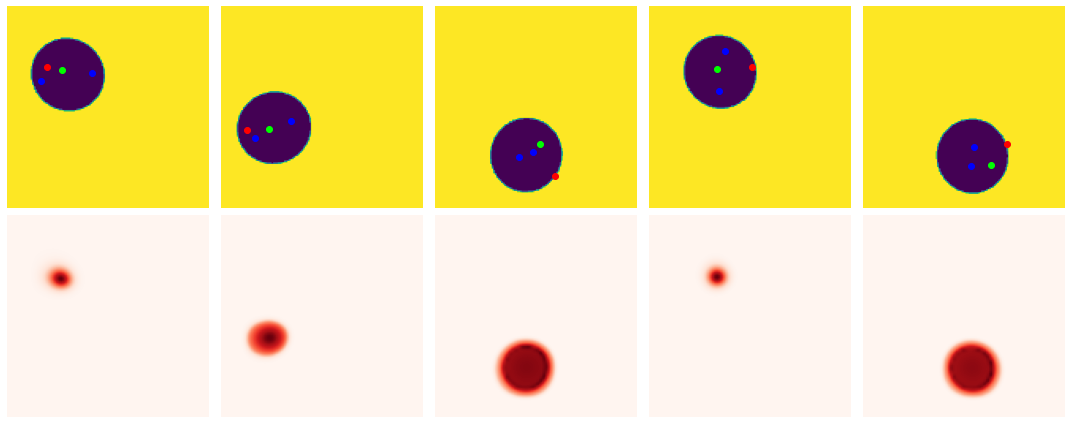

In [35]:
n_rows, n_cols, size = 2, 5, 3
axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*size, n_rows*size))[1]
model_sphere3.eval()
with torch.no_grad():
  for ax_col in axs.T:
        img, pts = spherical_data_fun(3) # Make new dataset
        print(img.shape)
        c, h, w = img.shape
        lgts = model_sphere3.forward(torch.from_numpy(img).float()[None])[0]  # (n_pts, h, w)
        probs = F.softmax(lgts.view(1, -1), dim=1).view(1, h, w)
        print(probs.shape)
        numpyprob0 = probs[0].cpu().detach().numpy()
        # cv2.imshow("test",numpyprob0)
        # cv2.waitKey(0)
        numpyprob0 = numpyprob0.reshape(-1)
        index = np.zeros(128*128)
        for i in range(0,128*128):
          index[i] = i
        pt0 = np.random.choice(a=index,p=numpyprob0)
        y = np.floor(pt0/128)
        x = np.floor(pt0%128)
        print("pts", pts)
        # print("x", x)
        # print("y",y)


        # add channel
        temp = np.zeros((h,w),dtype=np.uint8)
        #print(pts[0])
        temp[int(y),int(x)]=1
        #print(temp.argmax())
        img = np.append(img,temp)
        img = img.reshape(-1,h,w)

        # # eval joint
        # lgts_joint = model_joint.forward(torch.from_numpy(img)[None])[0]  # (n_pts, h, w)
        # probs_joint = F.softmax(lgts_joint.view(1, -1), dim=1).view(1, h, w)
        

        ax_col[0].imshow(img[0]) # , cmap='gray'
        ax_col[0].scatter(pts[2,0],pts[2,1], c=[(1, 0, 0)])
        ax_col[0].scatter(pts[0,0],pts[0,1], c=[(0, 0, 1)])
        ax_col[0].scatter(pts[1,0],pts[1,1], c=[(0, 0, 1)])
        
        # #print(probs_joint.shape)
        ax_col[1].imshow(probs[0], cmap='Reds')

        y = np.floor(np.argmax(probs[0].cpu().detach().numpy())/128)

        x = np.floor(np.argmax(probs[0].cpu().detach().numpy())%128)
        print("x", x)
        print("y",y)
        # #ax_col[1].imshow(img[0], cmap='gray')
        ax_col[0].scatter(x,y, c=[(0, 1, 0)])
        
        
for ax in axs.reshape(-1):
    ax.axis('off')
plt.tight_layout()

(4, 128, 128)
torch.Size([1, 128, 128])
pts [[97 55]
 [70 84]
 [63 63]
 [99 79]]
x 85.0
y 72.0
(4, 128, 128)
torch.Size([1, 128, 128])
pts [[ 85  36]
 [111  71]
 [118  40]
 [ 80  66]]
x 97.0
y 59.0
(4, 128, 128)
torch.Size([1, 128, 128])
pts [[ 99  20]
 [ 83  34]
 [110  31]
 [ 68  25]]
x 87.0
y 26.0
(4, 128, 128)
torch.Size([1, 128, 128])
pts [[43 10]
 [26 47]
 [56 34]
 [14 21]]
x 28.0
y 24.0
(4, 128, 128)
torch.Size([1, 128, 128])
pts [[ 7 54]
 [43 69]
 [43 63]
 [15 62]]
x 20.0
y 62.0


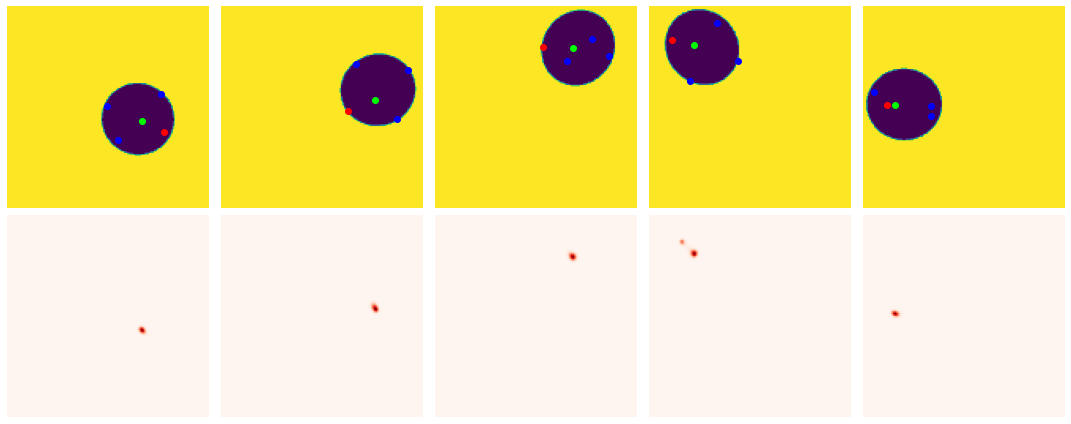

In [36]:
n_rows, n_cols, size = 2, 5, 3
axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*size, n_rows*size))[1]
model_sphere4.eval()
with torch.no_grad():
  for ax_col in axs.T:
        img, pts = spherical_data_fun(4) # Make new dataset
        print(img.shape)
        c, h, w = img.shape
        lgts = model_sphere4.forward(torch.from_numpy(img).float()[None])[0]  # (n_pts, h, w)
        probs = F.softmax(lgts.view(1, -1), dim=1).view(1, h, w)
        print(probs.shape)
        numpyprob0 = probs[0].cpu().detach().numpy()
        # cv2.imshow("test",numpyprob0)
        # cv2.waitKey(0)
        numpyprob0 = numpyprob0.reshape(-1)
        index = np.zeros(128*128)
        for i in range(0,128*128):
          index[i] = i
        pt0 = np.random.choice(a=index,p=numpyprob0)
        y = np.floor(pt0/128)
        x = np.floor(pt0%128)
        print("pts", pts)
        # print("x", x)
        # print("y",y)


        # add channel
        temp = np.zeros((h,w),dtype=np.uint8)
        #print(pts[0])
        temp[int(y),int(x)]=1
        #print(temp.argmax())
        img = np.append(img,temp)
        img = img.reshape(-1,h,w)

        # # eval joint
        # lgts_joint = model_joint.forward(torch.from_numpy(img)[None])[0]  # (n_pts, h, w)
        # probs_joint = F.softmax(lgts_joint.view(1, -1), dim=1).view(1, h, w)
        

        ax_col[0].imshow(img[0]) # , cmap='gray'
        ax_col[0].scatter(pts[3,0],pts[3,1], c=[(1, 0, 0)])
        ax_col[0].scatter(pts[0,0],pts[0,1], c=[(0, 0, 1)])
        ax_col[0].scatter(pts[1,0],pts[1,1], c=[(0, 0, 1)])
        ax_col[0].scatter(pts[2,0],pts[2,1], c=[(0, 0, 1)])
        # #print(probs_joint.shape)
        ax_col[1].imshow(probs[0], cmap='Reds')

        y = np.floor(np.argmax(probs[0].cpu().detach().numpy())/128)

        x = np.floor(np.argmax(probs[0].cpu().detach().numpy())%128)
        print("x", x)
        print("y",y)
        # #ax_col[1].imshow(img[0], cmap='gray')
        ax_col[0].scatter(x,y, c=[(0, 1, 0)])
        
        
for ax in axs.reshape(-1):
    ax.axis('off')
plt.tight_layout()

(1, 128, 128)
torch.Size([1, 128, 128])
pts [[ 53  76]
 [ 84 104]
 [ 75  92]
 [ 57  85]]
x 65.0
y 82.0
torch.Size([1, 128, 128])
pts [[ 53  76]
 [ 84 104]
 [ 75  92]
 [ 57  85]]
x 62.0
y 84.0
torch.Size([1, 128, 128])
pts [[ 53  76]
 [ 84 104]
 [ 75  92]
 [ 57  85]]
x 70.0
y 85.0
torch.Size([1, 128, 128])
pts [[ 53  76]
 [ 84 104]
 [ 75  92]
 [ 57  85]]
x 71.0
y 88.0
(1, 128, 128)
torch.Size([1, 128, 128])
pts [[ 32  89]
 [ 40  93]
 [ 31 114]
 [ 40  69]]
x 38.0
y 86.0
torch.Size([1, 128, 128])
pts [[ 32  89]
 [ 40  93]
 [ 31 114]
 [ 40  69]]
x 42.0
y 88.0
torch.Size([1, 128, 128])
pts [[ 32  89]
 [ 40  93]
 [ 31 114]
 [ 40  69]]
x 33.0
y 90.0
torch.Size([1, 128, 128])
pts [[ 32  89]
 [ 40  93]
 [ 31 114]
 [ 40  69]]
x 38.0
y 92.0
(1, 128, 128)
torch.Size([1, 128, 128])
pts [[94 24]
 [89 39]
 [98 12]
 [84 54]]
x 78.0
y 24.0
torch.Size([1, 128, 128])
pts [[94 24]
 [89 39]
 [98 12]
 [84 54]]
x 95.0
y 65.0
torch.Size([1, 128, 128])
pts [[94 24]
 [89 39]
 [98 12]
 [84 54]]
x 103.0
y 19.0
to

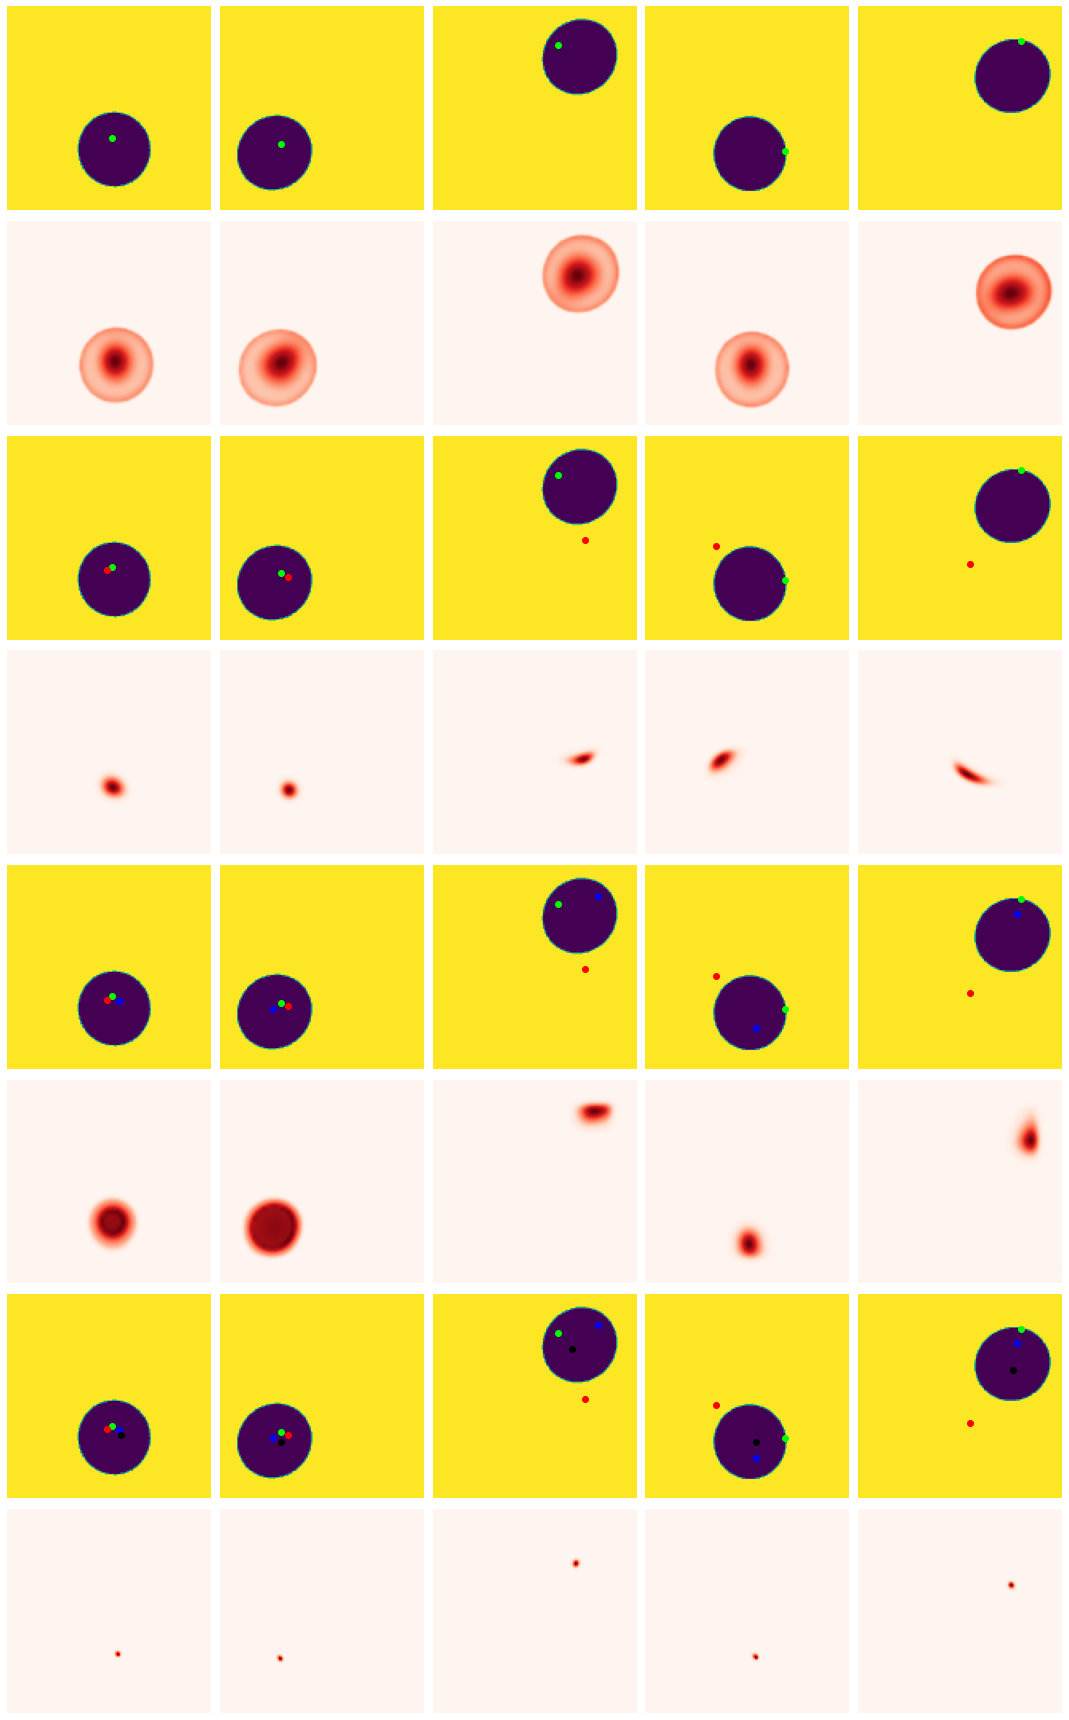

In [37]:
n_rows, n_cols, size = 8, 5, 3
axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*size, n_rows*size))[1]
model_sphere1.eval()
model_sphere2.eval()
model_sphere3.eval()
model_sphere4.eval()
with torch.no_grad():
  for ax_col in axs.T:
        img, pts = spherical_data_fun(1) # Make new dataset
        print(img.shape)
        c, h, w = img.shape
        lgts = model_sphere1.forward(torch.from_numpy(img).float()[None])[0]  # (n_pts, h, w)
        probs = F.softmax(lgts.view(1, -1), dim=1).view(1, h, w)
        print(probs.shape)
        numpyprob0 = probs[0].cpu().detach().numpy()
        # cv2.imshow("test",numpyprob0)
        # cv2.waitKey(0)
        numpyprob0 = numpyprob0.reshape(-1)
        index = np.zeros(128*128)
        for i in range(0,128*128):
          index[i] = i
        pt0 = np.random.choice(a=index,p=numpyprob0)
        y = np.floor(pt0/128)
        x = np.floor(pt0%128)
        print("pts", pts)
        # print("x", x)
        # print("y",y)


        # add channel
        temp = np.zeros((h,w),dtype=np.uint8)
        #print(pts[0])
        temp[int(y),int(x)]=1
        #print(temp.argmax())
        img = np.append(img,temp)
        img = img.reshape(-1,h,w)

        # # eval joint
        # lgts_joint = model_joint.forward(torch.from_numpy(img)[None])[0]  # (n_pts, h, w)
        # probs_joint = F.softmax(lgts_joint.view(1, -1), dim=1).view(1, h, w)
        

        ax_col[0].imshow(img[0]) # , cmap='gray'
        #ax_col[0].scatter(pts[0,0],pts[0,1], c=[(1, 0, 0)])
        
        # #print(probs_joint.shape)
        ax_col[1].imshow(probs[0], cmap='Reds')

        #y = np.floor(np.argmax(probs[0].cpu().detach().numpy())/128)

        #x = np.floor(np.argmax(probs[0].cpu().detach().numpy())%128)
        print("x", x)
        print("y",y)
        # #ax_col[1].imshow(img[0], cmap='gray')
        ax_col[0].scatter(x,y, c=[(0, 1, 0)])

        tempx = []
        tempy = []
        tempx.append(x)
        tempy.append(y)

        
        ##############################################################################################
        lgts = model_sphere2.forward(torch.from_numpy(img).float()[None])[0]  # (n_pts, h, w)
        probs = F.softmax(lgts.view(1, -1), dim=1).view(1, h, w)
        print(probs.shape)
        numpyprob0 = probs[0].cpu().detach().numpy()
        # cv2.imshow("test",numpyprob0)
        # cv2.waitKey(0)
        numpyprob0 = numpyprob0.reshape(-1)
        index = np.zeros(128*128)
        for i in range(0,128*128):
          index[i] = i
        pt0 = np.random.choice(a=index,p=numpyprob0)
        y = np.floor(pt0/128)
        x = np.floor(pt0%128)
        print("pts", pts)
        # print("x", x)
        # print("y",y)


        # add channel
        temp = np.zeros((h,w),dtype=np.uint8)
        #print(pts[0])
        temp[int(y),int(x)]=1
        #print(temp.argmax())
        img = np.append(img,temp)
        img = img.reshape(-1,h,w)

        # # eval joint
        # lgts_joint = model_joint.forward(torch.from_numpy(img)[None])[0]  # (n_pts, h, w)
        # probs_joint = F.softmax(lgts_joint.view(1, -1), dim=1).view(1, h, w)
        

        ax_col[2].imshow(img[0]) # , cmap='gray'
        ax_col[2].scatter(tempx[0],tempy[0], c=[(0, 1, 0)])
        
        # #print(probs_joint.shape)
        ax_col[3].imshow(probs[0], cmap='Reds')

        #y = np.floor(np.argmax(probs[0].cpu().detach().numpy())/128)

        #x = np.floor(np.argmax(probs[0].cpu().detach().numpy())%128)
        print("x", x)
        print("y",y)
        # #ax_col[1].imshow(img[0], cmap='gray')
        ax_col[2].scatter(x,y, c=[(1, 0, 0)])

        tempx.append(x)
        tempy.append(y)

        ############################################################################

        lgts = model_sphere3.forward(torch.from_numpy(img).float()[None])[0]  # (n_pts, h, w)
        probs = F.softmax(lgts.view(1, -1), dim=1).view(1, h, w)
        print(probs.shape)
        numpyprob0 = probs[0].cpu().detach().numpy()
        # cv2.imshow("test",numpyprob0)
        # cv2.waitKey(0)
        numpyprob0 = numpyprob0.reshape(-1)
        index = np.zeros(128*128)
        for i in range(0,128*128):
          index[i] = i
        pt0 = np.random.choice(a=index,p=numpyprob0)
        y = np.floor(pt0/128)
        x = np.floor(pt0%128)
        print("pts", pts)
        # print("x", x)
        # print("y",y)


        # add channel
        temp = np.zeros((h,w),dtype=np.uint8)
        #print(pts[0])
        temp[int(y),int(x)]=1
        #print(temp.argmax())
        img = np.append(img,temp)
        img = img.reshape(-1,h,w)

        # # eval joint
        # lgts_joint = model_joint.forward(torch.from_numpy(img)[None])[0]  # (n_pts, h, w)
        # probs_joint = F.softmax(lgts_joint.view(1, -1), dim=1).view(1, h, w)
        

        ax_col[4].imshow(img[0]) # , cmap='gray'
        ax_col[4].scatter(tempx[0],tempy[0], c=[(0, 1, 0)])
        ax_col[4].scatter(tempx[1],tempy[1], c=[(1, 0, 0)])
        
        # #print(probs_joint.shape)
        ax_col[5].imshow(probs[0], cmap='Reds')

        #y = np.floor(np.argmax(probs[0].cpu().detach().numpy())/128)

        #x = np.floor(np.argmax(probs[0].cpu().detach().numpy())%128)
        print("x", x)
        print("y",y)
        # #ax_col[1].imshow(img[0], cmap='gray')
        ax_col[4].scatter(x,y, c=[(0, 0, 1)])
        
        tempx.append(x)
        tempy.append(y)

        ###########################################################

        lgts = model_sphere4.forward(torch.from_numpy(img).float()[None])[0]  # (n_pts, h, w)
        probs = F.softmax(lgts.view(1, -1), dim=1).view(1, h, w)
        print(probs.shape)
        numpyprob0 = probs[0].cpu().detach().numpy()
        # cv2.imshow("test",numpyprob0)
        # cv2.waitKey(0)
        numpyprob0 = numpyprob0.reshape(-1)
        index = np.zeros(128*128)
        for i in range(0,128*128):
          index[i] = i
        pt0 = np.random.choice(a=index,p=numpyprob0)
        y = np.floor(pt0/128)
        x = np.floor(pt0%128)
        print("pts", pts)
        # print("x", x)
        # print("y",y)


        # add channel
        temp = np.zeros((h,w),dtype=np.uint8)
        #print(pts[0])
        temp[int(y),int(x)]=1
        #print(temp.argmax())
        img = np.append(img,temp)
        img = img.reshape(-1,h,w)

        # # eval joint
        # lgts_joint = model_joint.forward(torch.from_numpy(img)[None])[0]  # (n_pts, h, w)
        # probs_joint = F.softmax(lgts_joint.view(1, -1), dim=1).view(1, h, w)
        

        ax_col[6].imshow(img[0]) # , cmap='gray'
        ax_col[6].scatter(tempx[0],tempy[0], c=[(0, 1, 0)])
        ax_col[6].scatter(tempx[1],tempy[1], c=[(1, 0, 0)])
        ax_col[6].scatter(tempx[2],tempy[2], c=[(0, 0, 1)])
        
        # #print(probs_joint.shape)
        ax_col[7].imshow(probs[0], cmap='Reds')

        #y = np.floor(np.argmax(probs[0].cpu().detach().numpy())/128)

        #x = np.floor(np.argmax(probs[0].cpu().detach().numpy())%128)
        print("x", x)
        print("y",y)
        # #ax_col[1].imshow(img[0], cmap='gray')
        ax_col[6].scatter(x,y, c=[(0, 0, 0)])
        
        


for ax in axs.reshape(-1):
    ax.axis('off')
plt.tight_layout()

In [38]:
model_sphere1.eval()
model_sphere2.eval()
model_sphere3.eval()
model_sphere4.eval()
with torch.no_grad():
    img, pts = spherical_data_fun(1)
    lgts = model_sphere1.forward(torch.from_numpy(img).float()[None])[0]  # (n_pts, h, w)
    probs = F.softmax(lgts.view(1, -1), dim=1).view(1, h, w)
    numpyprob0 = probs[0].cpu().detach().numpy()
        # cv2.imshow("test",numpyprob0)
        # cv2.waitKey(0)
    numpyprob0 = numpyprob0.reshape(-1)
    index = np.zeros(128*128)
    for i in range(0,128*128):
        index[i] = i
    pt0 = np.random.choice(a=index,p=numpyprob0)
    y1 = np.floor(pt0/128)
    x1 = np.floor(pt0%128)
        # add channel
    temp = np.zeros((h,w),dtype=np.uint8)
    #print(pts[0])
    temp[int(y1),int(x1)]=1
    #print(temp.argmax())
    img = np.append(img,temp)
    img = img.reshape(-1,h,w)


    lgts = model_sphere2.forward(torch.from_numpy(img).float()[None])[0]  # (n_pts, h, w)
    probs = F.softmax(lgts.view(1, -1), dim=1).view(1, h, w)
    numpyprob0 = probs[0].cpu().detach().numpy()
        # cv2.imshow("test",numpyprob0)
        # cv2.waitKey(0)
    numpyprob0 = numpyprob0.reshape(-1)
    index = np.zeros(128*128)
    for i in range(0,128*128):
        index[i] = i
    pt0 = np.random.choice(a=index,p=numpyprob0)
    y2 = np.floor(pt0/128)
    x2 = np.floor(pt0%128)
        # add channel
    temp = np.zeros((h,w),dtype=np.uint8)
    #print(pts[0])
    temp[int(y1),int(x1)]=1
    #print(temp.argmax())
    img = np.append(img,temp)
    img = img.reshape(-1,h,w)


    lgts = model_sphere3.forward(torch.from_numpy(img).float()[None])[0]  # (n_pts, h, w)
    probs = F.softmax(lgts.view(1, -1), dim=1).view(1, h, w)
    numpyprob0 = probs[0].cpu().detach().numpy()
        # cv2.imshow("test",numpyprob0)
        # cv2.waitKey(0)
    numpyprob0 = numpyprob0.reshape(-1)
    index = np.zeros(128*128)
    for i in range(0,128*128):
        index[i] = i
    pt0 = np.random.choice(a=index,p=numpyprob0)
    y3 = np.floor(pt0/128)
    x3 = np.floor(pt0%128)
        # add channel
    temp = np.zeros((h,w),dtype=np.uint8)
    #print(pts[0])
    temp[int(y1),int(x1)]=1
    #print(temp.argmax())
    img = np.append(img,temp)
    img = img.reshape(-1,h,w)



    lgts = model_sphere4.forward(torch.from_numpy(img).float()[None])[0]  # (n_pts, h, w)
    probs = F.softmax(lgts.view(1, -1), dim=1).view(1, h, w)
    numpyprob0 = probs[0].cpu().detach().numpy()
        # cv2.imshow("test",numpyprob0)
        # cv2.waitKey(0)
    numpyprob0 = numpyprob0.reshape(-1)
    index = np.zeros(128*128)
    for i in range(0,128*128):
        index[i] = i
    pt0 = np.random.choice(a=index,p=numpyprob0)
    y4 = np.floor(pt0/128)
    x4 = np.floor(pt0%128)
        # add channel
    temp = np.zeros((h,w),dtype=np.uint8)
    #print(pts[0])
    temp[int(y1),int(x1)]=1
    #print(temp.argmax())
    img = np.append(img,temp)
    img = img.reshape(-1,h,w)




    Ransac_ITER = 100000
    pnp_imagePoints = []
    pnp_objectPoints = []
    pnp_distCoeff = np.zeros(4)

    result1 = np.array([x1,y1])
    result2 = np.array([x2,y2])
    result3 = np.array([x3,y3])
    result4 = np.array([x4,y4])
    width = w
    height = h
    point_poses = np.array([[[1. , 0. , 0. , 1.],
                    [0. , 1. , 0. , 0. ],
                    [0. , 0. , 1. , 0. ],
                    [0. , 0. , 0. , 1. ]],
                [[1. , 0. , 0. , -1.],
                    [0. , 1. , 0. , 0. ],
                    [0. , 0. , 1. , 0. ],
                    [0. , 0. , 0. , 1. ]],
                [[1. , 0. , 0. , 0.],
                    [0. , 1. , 0. , 1. ],
                    [0. , 0. , 1. , 0. ],
                    [0. , 0. , 0. , 1. ]],
                [[1. , 0. , 0. , 0.],
                    [0. , 1. , 0. , -1. ],
                    [0. , 0. , 1. , 0. ],
                    [0. , 0. , 0. , 1. ]],
                [[1. , 0. , 0. , 0.],
                    [0. , 1. , 0. , -1.5 ],
                    [0. , 0. , 1. , 0. ],
                    [0. , 0. , 0. , 1. ]]])
    
    cam_pose = np.array([[1. , 0. , 0. , 0.],
                    [0. , 1. , 0. , 0. ],
                    [0. , 0. , 1. , 5. ],
                    [0. , 0. , 0. , 1. ]])
    yfov = np.pi / 3.0
    fovy_pixel = (width / 2.) / np.tan(yfov / 2.)

    pnp_imagePoints.extend((result1[:2], result2[:2], result3[:2], result4[:2]))
    pnp_imagePoints = np.array(pnp_imagePoints)
    #print(pnp_imagePoints)

    #pnp_objectPoints.extend((point_poses[0][:3,3],point_poses[1][:3,3], point_poses[2][:3,3], point_poses[3][:3,3]))
    pnp_objectPoints.extend((point_poses[0][:3,3],point_poses[1][:3,3], point_poses[2][:3,3], point_poses[3][:3,3]))

    pnp_objectPoints = np.array(pnp_objectPoints)
    #print(pnp_objectPoints)


    pnp_camMatrix = np.array([[fovy_pixel, 0, (width-1.)/2.],[0, fovy_pixel, (height-1.)/2.],[0, 0, 1]])

    #print("pnp_cam_mat: ",pnp_camMatrix)

    succes, pnp_R, pnp_t, inliers = cv2.solvePnPRansac(pnp_objectPoints, pnp_imagePoints, pnp_camMatrix, None, iterationsCount=Ransac_ITER)
    #succes, pnp_R, pnp_t = cv2.solvePnP(pnp_objectPoints, pnp_imagePoints, pnp_camMatrix, None)

    if succes == True:
        print("SolvePnPRansac succeeded")
        cvToGl = np.zeros((4, 4))
        cvToGl[0,0] = 1.
        cvToGl[1,1] = -1.
        cvToGl[2,2] = -1.
        cvToGl[3,3] = 1.

        #print("cvToGL: \n", cvToGl)

        R_pnp, _ = cv2.Rodrigues(pnp_R)
        t = pnp_t[:, 0]

        R_pnp = np.transpose(R_pnp)
        t = np.dot(-R_pnp, t)

        T = np.empty((4,4))
        T[:3, :3] = R_pnp
        T[:3, 3] = t
        T[3, :] = [0, 0, 0, 1]

        # camPos = np.linalg.inv(T)
        # print("CamPos: \n", camPos)

        world_to_cam = inv(cam_pose)
        #print("World to cam: \n", world_to_cam)

        #print("Rand_Trans: \n", rand_trans)
        # print("Succes?:",succes)
        # print("pnp_R: ",R)
        # print("pnp_t: ",t)

        # print("T: \n", np.linalg.inv(T))
        CamPose = cvToGl@np.linalg.inv(T)
        CamPose1 = np.linalg.inv(T)

        # print("CamPose: \n", CamPose)

        Rot_cam = CamPose1[:3,:3]
        t_cam = CamPose1[:3,3]





        # print("Rot_cam: ", Rot_cam)

        # Pose_of_object = world_to_cam@T
        # print("Pose of object: \n", Pose_of_object)


        # p1, _ = cv2.projectPoints(transformed_point_poses[0][:3,3],Rot,t,pnp_camMatrix, None)
        # p2, _ = cv2.projectPoints(transformed_point_poses[1][:3,3],Rot,t,pnp_camMatrix, None)
        # p3, _ = cv2.projectPoints(transformed_point_poses[2][:3,3],Rot,t,pnp_camMatrix, None)
        # p4, _ = cv2.projectPoints(transformed_point_poses[3][:3,3],Rot,t,pnp_camMatrix, None)

        p1, _ = cv2.projectPoints(point_poses[0][:3,3],Rot_cam,t_cam,pnp_camMatrix, None)
        p2, _ = cv2.projectPoints(point_poses[1][:3,3],Rot_cam,t_cam,pnp_camMatrix, None)
        p3, _ = cv2.projectPoints(point_poses[2][:3,3],Rot_cam,t_cam,pnp_camMatrix, None)
        p4, _ = cv2.projectPoints(point_poses[3][:3,3],Rot_cam,t_cam,pnp_camMatrix, None)




        c1 = (int(p1[0][0][0]),int(p1[0][0][1]))
        c2 = (int(p2[0][0][0]),int(p2[0][0][1]))
        c3 = (int(p3[0][0][0]),int(p3[0][0][1]))
        c4 = (int(p4[0][0][0]),int(p4[0][0][1]))

        #print("p1", center)
        center = [c1, c2, c3, c4]
        print(img.shape)
        for c in center:
            img1 = cv2.circle(img[0], c, 0, [0,0,255], -1)

        img1 = cv2.resize(img1.astype(np.uint8), (800,800))
        while(1):        
            cv2.imshow('Result plot', img1)
            key = cv2.waitKey(33)
            if key == 27:
                break

        print("Distance between each of the four points: ")
        for i in range(4):
            dist = np.linalg.norm(pnp_imagePoints[i]-center[i])
            #print(center[i])
            #print(pnp_imagePoints[i])
            print(dist)
    else:
        print("SolvePnPRansac failed")

SolvePnPRansac succeeded
(5, 128, 128)
Distance between each of the four points: 
1.0
1.0
1.0
32.31098884280702
